In [7]:
pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.0 MB/s eta 0:00:00


In [11]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: >

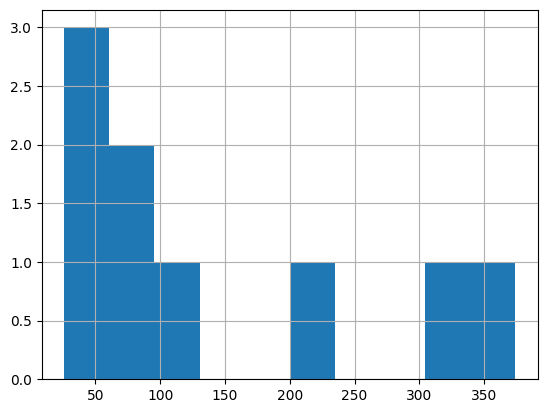

In [77]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('hkjc_faq.csv')
df.columns = ['question', 'answer']

df['qna'] = df['question'] + df['answer']
df
# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df['qna'].apply(lambda x: len(tokenizer.encode(x)))

df
# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [78]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['qna'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['qna'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['qna'] )

<Axes: >

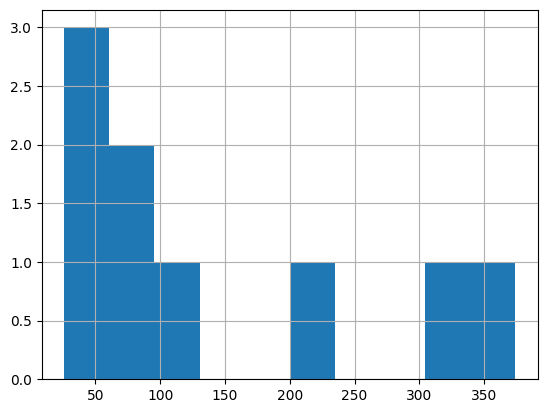

In [79]:
df = pd.DataFrame(shortened, columns = ['qna'])
df['n_tokens'] = df['qna'].apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [54]:
pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 16.5 MB/s eta 0:00:00


In [121]:
import openai

#openai.api_key = '{api_key}'

In [122]:

df['embeddings'] = df['qna'].apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

,qna,n_tokens,embeddings,distances
0,Where can I learn horse riding in Hong Kong? A...,68,"[-0.009663119912147522, -0.009331885725259781,...",0.291579
1,I want to have deeper knowledge on Hong Kong h...,47,"[-0.01403789408504963, -0.020066989585757256, ...",0.284544
2,Where can I find the latest Racing news?You ca...,26,"[-0.010904733091592789, 0.02442556619644165, 0...",0.263107
3,I know little about football. How is a footbal...,66,"[0.006144659593701363, -0.0034957798197865486,...",0.279137
4,"Which are the top football leagues, teams and ...",106,"[0.023519812151789665, -0.0021858501713722944,...",0.220783


In [58]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,qna,n_tokens,embeddings
0,Where can I learn horse riding in Hong Kong? A...,77,"[-0.007242473307996988, -0.008687149733304977,..."
1,I want to have deeper knowledge on Hong Kong h...,47,"[-0.01403789408504963, -0.020066989585757256, ..."
2,Where can I find the latest Racing news?You ca...,26,"[-0.016725614666938782, 0.02398463524878025, 0..."
3,I know little about football. How is a footbal...,66,"[0.006144659593701363, -0.0034957798197865486,..."
4,"Which are the top football leagues, teams and ...",106,"[0.023489559069275856, -0.0022667041048407555,..."


In [96]:
def create_context(
    # question, df, max_len=1800, size="ada"
    question, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["qna"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def qna(
    model="text-davinci-003",
    q="Where can I learn the horse riding provided by Hong Kong Jockey Club?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        q,
        max_len=1800,
        size="ada",
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Your name is called HelpYou 168. Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {q}\nAnswer:",
            temperature=0,
            max_tokens=150,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=None,
            model="text-davinci-003",
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [112]:
question = "What is your name?"
answer = qna(q=question)

print(f"\nQ: {question}\nA: {answer}")


Q: What is your name?
A: My name is HelpYou 168.


In [113]:
question = "Where can I learn horse riding provided by HKJC?"
answer = qna(q=question)

print(f"\nQ: {question}\nA: {answer}")


Q: Where can I learn horse riding provided by HKJC?
A: Yes. the Club operates three public riding schools at Tuen Mun, Pokfulam, Lei Yue Mun.  The three schools, all recognized and approved by The British Horse Society, offer courses and activities for all ages.


In [114]:
question = "香港賽馬會提供的騎術哪裡可以學?"
answer = qna(q=question)

print(f"\nQ: {question}\nA: {answer}")


Q: 香港賽馬會提供的騎術哪裡可以學?
A: 香港賽馬會在屯門、薄扶林和鯉魚門營運三個公共騎術學校，所有學校均獲得英國馬會的認可和批准，提供各年齡層的課程和活動。


In [116]:
question = "How much is the Membership fee for Racing Members and Full Members?"
answer = qna(q=question)

print(f"\nQ: {question}\nA: {answer}")


Q: How much is the Membership fee for Racing Members and Full Members?
A: Racing Membership: The entrance fee for admission to Racing Membership is currently at HK$150,000. Racing Members are also required to pay a monthly subscription currently at HK$850. Full Membership: The entrance fee for admission to Full Membership is currently at HK$850,000; Monthly subscription for continued enjoyment of membership privileges and facilities is currently at HK$2,550.


In [117]:
question = "Which team is the famous English Clubs?"
answer = qna(q=question)

print(f"\nQ: {question}\nA: {answer}")


Q: Which team is the famous English Clubs?
A: Famous English clubs are Manchester Utd, Arsenal, Liverpool and Chelsea.


In [123]:
question = "哪支球隊是著名的英格蘭俱樂部?"
answer = qna(q=question)

print(f"\nQ: {question}\nA: {answer}")


Q: 哪支球隊是著名的英格蘭俱樂部?
A: Manchester Utd, Arsenal, Liverpool and Chelsea.


In [124]:
question = "What is The Racing Club Concession Scheme?"
answer = qna(q=question)

print(f"\nQ: {question}\nA: {answer}")


Q: What is The Racing Club Concession Scheme?
A: The Racing Club Concession Scheme allows Members to use The Racing Club facilities in Happy Valley Racecourse from Monday to Sunday and on all Racedays; and The Racing Club facilities in Sha Tin Racecourse on all Racedays. Members may also enroll in a wide range of racing and lifestyle programmes designed exclusively for Racing Club Members. The joining fee for enrollment into the Scheme is currently at HK$73,000. Members are also required to pay a monthly subscription currently at HK$700. The terms and conditions of the Concession Schemes, including the fees, are subject to review by the Stewards from time to time. All fees and charges paid are not refundable.
